In [1]:
import numpy as np
import h5py
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

In [2]:
def make_matrix(filename):
    h5f = h5py.File(filename, 'r')
    data = h5f['data'][:]
    patient_list = h5f['patient-list'][:]
    h5f.close()
    return data, patient_list

## HNU-1 Dataset Results

In [3]:
X, patients = make_matrix('../../src/data/HNU1.h5')

from src.features.summary_17 import Stats

data_matrix = []
for i in X:
    adj = np.matrix(i)

    g = nx.from_numpy_matrix(adj)
    stats = Stats(g).return_stats()
    data_matrix.append(np.array(stats))

data_matrix = np.matrix(data_matrix)

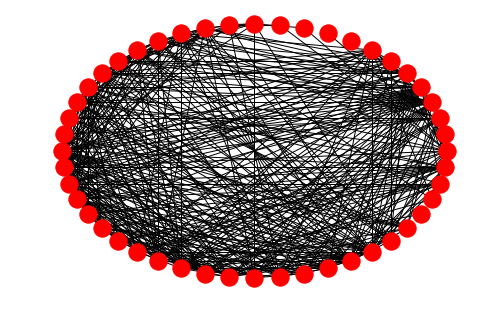

In [48]:
nx.draw_circular(g)

Prior to projection, results appears to indicate only 2 clusters with a high silhouette score. We know that we should be seeing 30 clusters in the HNU dataset.

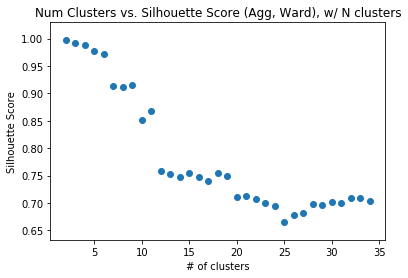

Best sillhouette score: [0.9977842346007438]
Best num clusters: [2]


In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
import math

best_ss = []
plt.figure()
plt.title('Num Clusters vs. Silhouette Score (Agg, Ward), w/ N clusters')
x = range(2,35)
silhouettes = []
for i in x:
    X = data_matrix
    clustering = AgglomerativeClustering(n_clusters=i).fit(X)
    silhouettes.append(silhouette_score(X, clustering.labels_, metric='sqeuclidean'))

plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.scatter(x, silhouettes)

best_ss.append(max(silhouettes))
plt.show()

print('Best sillhouette score:', best_ss)
print('Best num clusters:', [x[i] for i in range(len(silhouettes)) if silhouettes[i]==max(silhouettes)])


After PCA into 2D, 2 clusters can be seen very clearly while 30 has overlapping clusters.

0.7016062640976537


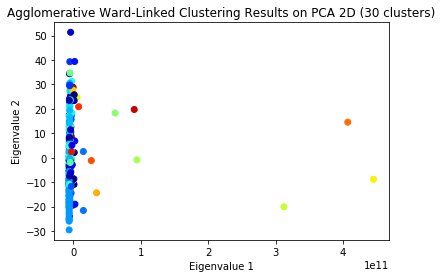

0.9977842346007438


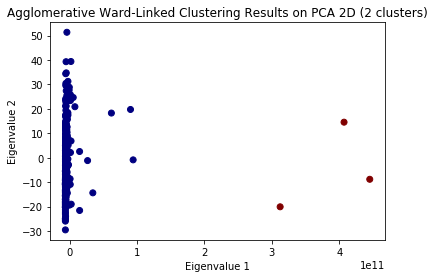

In [40]:
# 30 clusters
pca = PCA(n_components=2, svd_solver='full')
X = pca.fit_transform(data_matrix)
aggclust = AgglomerativeClustering(n_clusters=30).fit(X)
# print(clustering.labels_)
print(silhouette_score(X, aggclust.labels_, metric='sqeuclidean'))

plt.figure()
plt.title("Agglomerative Ward-Linked Clustering Results on PCA 2D (30 clusters)")
plt.xlabel("Eigenvalue 1")
plt.ylabel("Eigenvalue 2")
plt.scatter(X[:, 0], X[:, 1], c=aggclust.labels_,cmap=plt.cm.jet)
plt.show()

# 2 clusters
pca = PCA(n_components=2, svd_solver='full')
X = pca.fit_transform(data_matrix)
aggclust = AgglomerativeClustering(n_clusters=2).fit(X)
# print(clustering.labels_)
print(silhouette_score(X, aggclust.labels_, metric='sqeuclidean'))

plt.figure()
plt.title("Agglomerative Ward-Linked Clustering Results on PCA 2D (2 clusters)")
plt.xlabel("Eigenvalue 1")
plt.ylabel("Eigenvalue 2")
plt.scatter(X[:, 0], X[:, 1], c=aggclust.labels_,cmap=plt.cm.jet)
plt.show()

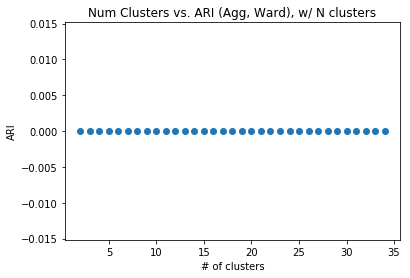

Best ARI: [0.0]
Best num clusters: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [46]:
# Computing ARI score for N clusters, no PCA
from sklearn.metrics import adjusted_rand_score

d = {ni: indi for indi, ni in enumerate(set(patients))}
true_labels = [d[ni] for ni in patients]

best_ari = []
plt.figure()
plt.title('Num Clusters vs. ARI (Agg, Ward), w/ N clusters')
x = range(2,35)
aris = []
for i in x:
    clustering = AgglomerativeClustering(n_clusters=i).fit(data_matrix)
    aris.append(adjusted_rand_score(true_labels, clustering.labels_))

plt.xlabel('# of clusters')
plt.ylabel('ARI')
plt.scatter(x, aris)

best_ari.append(max(aris))
plt.show()

print('Best ARI:', best_ari)
print('Best num clusters:', [x[i] for i in range(len(aris)) if aris[i]==max(aris)])
